# Pune Air Quality Index Predictor

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import randint,uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

## Analyzing imported dataset

In [4]:
data = pd.read_csv('PNQ_AQI.csv')

In [5]:
data.head()

,Date,SO2 µg/m3,Nox µg/m3,RSPM µg/m3,SPM,CO2 µg/m3,AQI,Location
0,2009-01-01 00:00:00,15,53,179.0,NaN,NaN,153.0,MPCB-KR
1,2009-02-01 00:00:00,15,48,156.0,NaN,NaN,137.0,MPCB-KR
2,2009-03-01 00:00:00,13,51,164.0,NaN,NaN,143.0,MPCB-KR
3,2009-04-01 00:00:00,8,37,135.0,NaN,NaN,123.0,MPCB-KR
4,2009-07-01 00:00:00,13,36,140.0,NaN,NaN,127.0,MPCB-KR


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7844 entries, 0 to 7843
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        7844 non-null   object 
 1   SO2 µg/m3   7844 non-null   object 
 2   Nox µg/m3   7844 non-null   object 
 3   RSPM µg/m3  7843 non-null   float64
 4   SPM         2970 non-null   float64
 5   CO2 µg/m3   0 non-null      float64
 6   AQI         7787 non-null   float64
 7   Location    7844 non-null   object 
dtypes: float64(4), object(4)
memory usage: 490.4+ KB


In [7]:
data.isnull().sum()

Date             0
SO2 µg/m3        0
Nox µg/m3        0
RSPM µg/m3       1
SPM           4874
CO2 µg/m3     7844
AQI             57
Location         0
dtype: int64

## Feature Engineering

### Dropping null column and sorting date

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
data.drop('CO2 µg/m3',axis=1,inplace=True)

In [10]:
data['Location'].value_counts()

Karve Road          2069
MPCB-KR             1386
Pimpri Chinchwad     854
Bhosari              605
Swargate             587
Nal Stop             575
MPCB-BSRI            417
MPCB-NS              405
MPCB-SWGT            381
MPCB-PMPR            311
Pimpri               254
Name: Location, dtype: int64

In [11]:
rep={'MPCB-KR':'Karve Road','MPCB-SWGT':'Swargate','MPCB-BSRI':'Bhosari','MPCB-NS':'Nal Stop','MPCB-PMPR':'Pimpri','Pimpri Chinchwad':'Chinchwad'}
data['Location'].replace(rep,inplace=True)

In [12]:
data.isnull().sum()

Date             0
SO2 µg/m3        0
Nox µg/m3        0
RSPM µg/m3       1
SPM           4874
AQI             57
Location         0
dtype: int64

In [13]:
data.sort_values(by=['Date'], inplace=True, ignore_index=True)

In [14]:
data.head()

,Date,SO2 µg/m3,Nox µg/m3,RSPM µg/m3,SPM,AQI,Location
0,2009-01-01,15,53,179.0,NaN,153.0,Karve Road
1,2009-01-01,19,60,161.0,366.0,141.0,Swargate
2,2009-01-02,BDL - NA,16,140.0,NaN,127.0,Karve Road
3,2009-01-04,26,28,102.0,261.0,101.0,Bhosari
4,2009-01-04,20,20,150.0,NaN,133.0,Karve Road


### Removing NaN/Na values

In [15]:
data.loc[data['Nox µg/m3']=='BDL -\xa0NA']

,Date,SO2 µg/m3,Nox µg/m3,RSPM µg/m3,SPM,AQI,Location
211,2009-04-30,BDL - NA,BDL - NA,NaN,0.0,0.0,Swargate
390,2009-08-13,BDL - NA,BDL - NA,64.0,NaN,64.0,Karve Road
392,2009-08-14,BDL - NA,BDL - NA,63.0,NaN,63.0,Karve Road
394,2009-08-15,BDL - NA,BDL - NA,50.0,NaN,50.0,Karve Road
395,2009-08-16,BDL - NA,BDL - NA,48.0,NaN,48.0,Karve Road
396,2009-08-17,BDL - NA,BDL - NA,62.0,NaN,62.0,Karve Road
1257,2011-01-06,4,BDL - NA,54.0,NaN,54.0,Karve Road
1310,2011-02-06,4,BDL - NA,53.0,NaN,53.0,Karve Road
1362,2011-03-06,5,BDL - NA,71.0,NaN,71.0,Karve Road
1417,2011-04-06,6,BDL - NA,64.0,NaN,64.0,Karve Road


In [16]:
data_test = data.copy()

In [17]:
for _, col in enumerate(list(data_test.columns[1:3])):
    data_test[f'{col} BDL'] = data_test[f'{col}'].map(lambda x: 1 if 'BDL' in x else 0)
    data_test[f'{col}'] = data_test[f'{col}'].apply(lambda x: x[-3:])
    data_test[f'{col}'] = data_test[f'{col}'].apply(lambda x: 0 if 'NA' in x else int((re.findall(r'\d+',x))[0]))

### Removing Outliers

In [18]:
outlier_features = list(data_test.columns[1:5])
def detect_outliers(df,n,features):
    outlier_indices = []
    
    for col in features:
        q1 = np.nanpercentile(df[col], 25)
        q3 = np.nanpercentile(df[col], 75)
        iqr = q3 - q1
        min_val = q1 - 1.5 * iqr
        max_val = q3 + 1.5 * iqr
        outlier_indices.extend(df[(df[col] < min_val) | (df[col] > max_val)].index)
    outlier_indices = Counter(outlier_indices)        
    outliers = list( key for key, value in outlier_indices.items() if value > n)
    return outliers

Outliers_to_drop = detect_outliers(data_test,1,outlier_features)
data_test.loc[Outliers_to_drop]

,Date,SO2 µg/m3,Nox µg/m3,RSPM µg/m3,SPM,AQI,Location,SO2 µg/m3 BDL,Nox µg/m3 BDL
1242,2010-12-28,65,128,372.0,NaN,328.0,Karve Road,0,0
1588,2011-07-12,52,60,300.0,555.0,250.0,Bhosari,0,0
1665,2011-08-24,56,60,239.0,735.0,193.0,Bhosari,0,0
1771,2011-10-26,54,142,225.0,NaN,183.0,Karve Road,0,0
1840,2011-12-01,95,85,237.0,618.0,191.0,Bhosari,0,0
1876,2011-12-21,59,52,271.0,417.0,221.0,Bhosari,0,0
1889,2011-12-28,59,85,267.0,610.0,217.0,Bhosari,0,0
1930,2012-01-14,60,75,285.0,406.0,235.0,Bhosari,0,0
1941,2012-01-18,61,71,307.0,454.0,257.0,Bhosari,0,0
4709,2014-12-23,53,9,280.0,NaN,230.0,Karve Road,0,0


In [19]:
data = data_test

In [20]:
data.drop(Outliers_to_drop, axis = 0, inplace=True)

### Removing null values

In [21]:
data.dropna(axis=0, subset=['AQI'], inplace=True)
data.fillna(method='bfill', axis=0, inplace=True)

In [22]:
data.isnull().sum()

Date             0
SO2 µg/m3        0
Nox µg/m3        0
RSPM µg/m3       0
SPM              0
AQI              0
Location         0
SO2 µg/m3 BDL    0
Nox µg/m3 BDL    0
dtype: int64

## Plotting features with target

c:\Users\yeshu\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\yeshu\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\yeshu\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

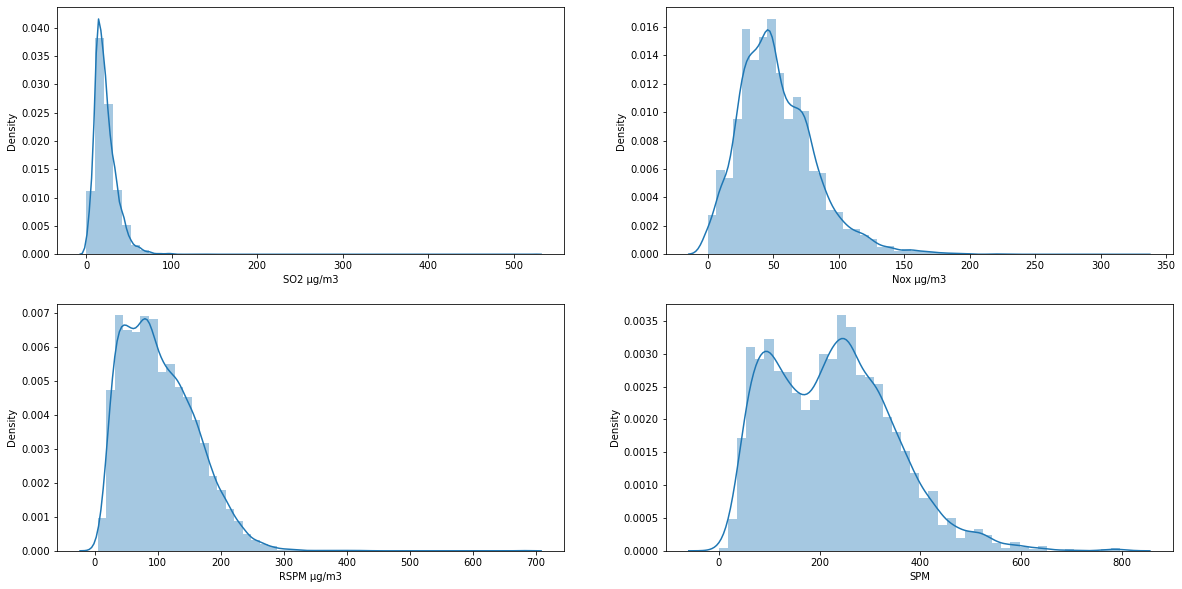

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.distplot(data['SO2 µg/m3'])
plt.subplot(2,2,2)
sns.distplot(data['Nox µg/m3'])
plt.subplot(2,2,3)
sns.distplot(data['RSPM µg/m3'])
plt.subplot(2,2,4)
sns.distplot(data['SPM'])
plt.show()

In [24]:
data = data[[c for c in data if c not in ['AQI']] + ['AQI']]

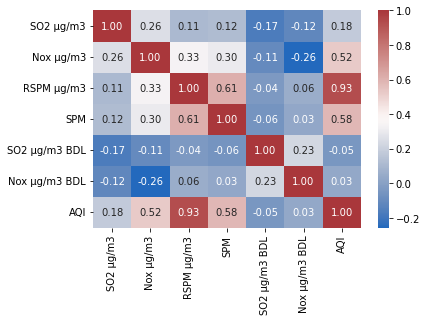

In [25]:
g1 = sns.heatmap(data.corr(),annot=True, fmt = ".2f", cmap = "vlag")

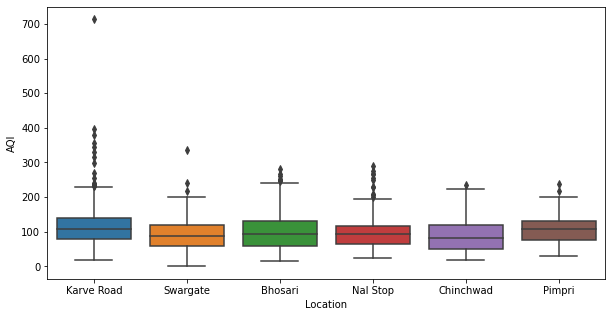

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Location',y='AQI',data=data)
plt.show()

In [27]:
d={}
for key,grp in data.groupby('Location'):
    a=grp.groupby(grp['Date'].dt.year)['AQI'].mean()
    d[key]=a
yearly_avg=pd.DataFrame(d)
yearly_avg.index.name='Years'
yearly_avg.reset_index(inplace=True)
yearly_avg.set_index('Years',inplace=True)
yearly_avg

,Bhosari,Chinchwad,Karve Road,Nal Stop,Pimpri,Swargate
Years,,,,,,
2009,86.745283,NaN,97.700000,83.592233,NaN,84.432432
2010,76.458333,NaN,109.573529,80.076923,NaN,75.571429
2011,109.571429,NaN,124.708571,99.607843,NaN,98.912088
2012,88.729167,89.558140,114.392655,88.878788,NaN,81.533981
2013,93.323529,81.468013,122.659218,81.155340,NaN,76.130000
2014,92.230000,89.460714,111.918919,87.591398,NaN,85.198113
2015,95.430000,NaN,137.198198,92.427083,140.490196,100.780220
2016,114.663265,NaN,107.250000,110.622222,101.698980,103.865169
2017,103.454545,NaN,77.108824,101.000000,140.000000,98.500000


Text(0.5, 0, 'Year')

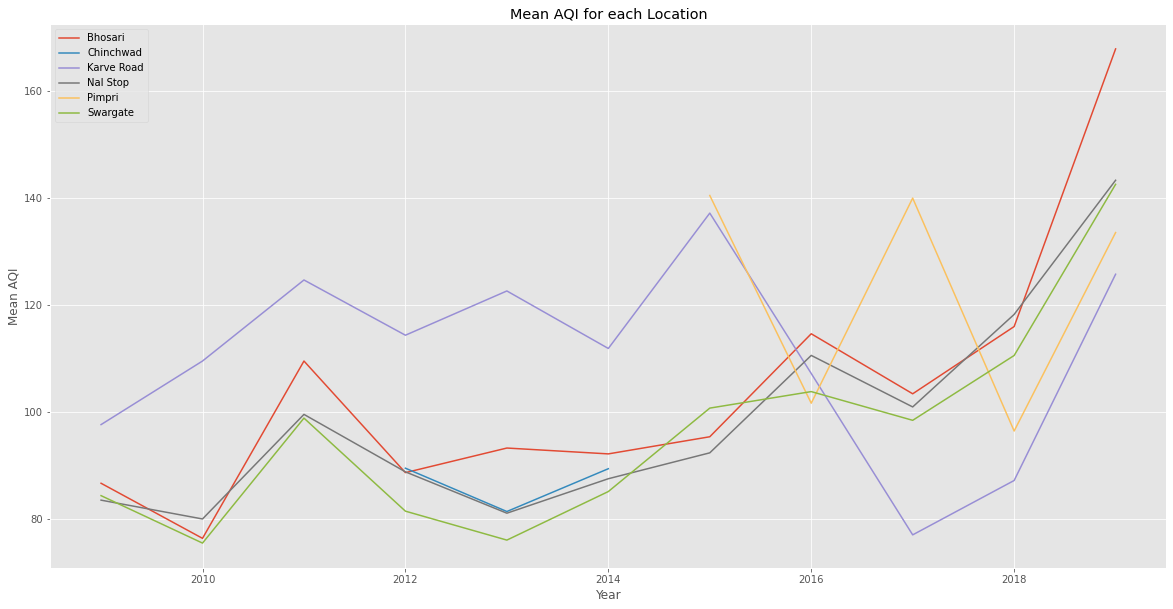

In [28]:
plt.style.use('ggplot')
yearly_avg.plot(figsize=(20,10))
plt.title('Mean AQI for each Location')
plt.ylabel('Mean AQI')
plt.xlabel('Year')

## Feature Selection

In [29]:
Location = pd.get_dummies(data.Location, prefix='Location', drop_first=True)
cols = [data, Location]
data = pd.concat(cols, axis=1)
data.drop(columns=['Location'], inplace=True)

In [30]:
y = data.AQI
data.drop(['AQI'], axis=1, inplace=True)

In [31]:
y = y.to_frame()

In [32]:
X = data.iloc[:,1:]

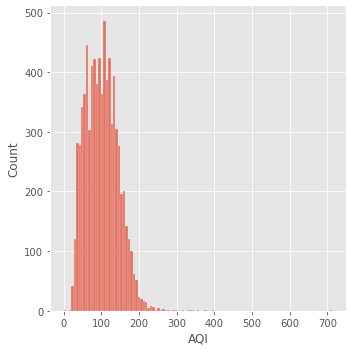

In [33]:
sns.displot(y['AQI'])

## Model training and optimization

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6199, 11), (1550, 11), (6199, 1), (1550, 1))

In [35]:
scaler = preprocessing.RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model training via Linear Regression

In [36]:
reg = LinearRegression().fit(X_train_scaled, y_train)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(reg, X_train_scaled, y_train, cv=cv)

array([0.91601183, 0.92927787, 0.92533043, 0.9263533 , 0.92035196])

In [37]:
y_pred = reg.predict(X_test_scaled)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

8.33496101140217
194.17234742042984


### Model training via RandomizedSearchCV using Random Forest Regressor

In [38]:
param_distributions = {'n_estimators': randint(1, 5),'max_depth': randint(5, 10)}
search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=0),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(X_train_scaled, y_train.values.ravel())
cross_val_score(search, X_train_scaled, y_train.values.ravel(), cv=cv)

array([0.9947581 , 0.99410261, 0.99298531, 0.99390462, 0.99599616])

### Model training via GridSearchCV using AdaBoost Regressor

In [39]:
ada_param_distributions = {'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
        'loss': ['linear', 'square', 'exponential']}
ada_search = GridSearchCV(AdaBoostRegressor(random_state=0),ada_param_distributions)
ada_search.fit(X_train_scaled, y_train.values.ravel())
cross_val_score(ada_search, X_train_scaled, y_train.values.ravel(), cv=cv)

array([0.94501495, 0.94253006, 0.93101046, 0.93696966, 0.93864815])

### Model training via StackingRegressor using Random Forest Regressor and Gradient Boosting Regressor

In [40]:
estimators = [('rf', search),('gbr', GradientBoostingRegressor(random_state=0))]
stacking_reg = \
    StackingRegressor(estimators=estimators,final_estimator=search)
stacked_reg = stacking_reg.fit(X_train_scaled, y_train.values.ravel())
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(stacked_reg, X_train_scaled, y_train.values.ravel(), cv=cv)

array([0.99445731, 0.98083378, 0.99471208, 0.99454153, 0.9972307 ])

### Model training via StackingRegressor using XGB RegressorRandom, Forest Regressor and Gradient Boosting Regressor

In [41]:
estimators = [('xb', XGBRegressor(random_state=4)),('gbr', GradientBoostingRegressor(random_state=4))]
stacking_reg_2 = StackingRegressor(estimators=estimators,final_estimator=search)
stacked_reg_2 = stacking_reg_2.fit(X_train_scaled, y_train.values.ravel())
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(stacked_reg_2, X_train_scaled, y_train.values.ravel(), cv=cv)

array([0.99051789, 0.98121053, 0.99841046, 0.99425911, 0.99631206])

### Score comparison

In [42]:
stacked_reg_2.score(X_test_scaled, y_test)

0.9616135332810467

In [43]:
scores = []

for i in range(10):
    scaled = preprocessing.RobustScaler()
    X_scaled = scaled.fit_transform(X)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size = 0.2)
    
    stacking_reg_model = StackingRegressor(estimators=estimators,final_estimator=search)
    stacked_reg_model = stacking_reg_model.fit(X_train_scaled, y_train.values.ravel())
    scores.append(stacked_reg_model.score(Xtest, ytest))

print(np.mean(scores))

0.988163167850928


In [44]:
scores = []

for i in range(10):
    scaled = preprocessing.RobustScaler()
    X_scaled = scaled.fit_transform(X)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size = 0.2)
    
    model = XGBRegressor()
    model.fit(Xtrain, ytrain)
    scores.append(model.score(Xtest, ytest))

print(np.mean(scores))

0.9982316144492284


In [58]:
scores = []

for i in range(10):   
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

    rf_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=9),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
    rf_search.fit(Xtrain, ytrain.values.ravel())
    scores.append(rf_search.score(Xtest, ytest.values.ravel()))

print(np.mean(scores))

0.9818003510496414


In [64]:
print("Best model is RandomizedSearchCV with a mean score of", np.mean(scores))

Best model is RandomizedSearchCV with a mean score of 0.9818003510496414


## Saving Best Model

In [52]:
import pickle
with open("pune_AQI_model.pkl", "wb") as file:
    pickle.dump(rf_search , file)

In [65]:
rf_search.score(Xtest, ytest.values.ravel())

0.9979024223000158

## Prediction Function

In [60]:
def predict_AQI(location, so2, nox, rspm, spm):
    loc = f"Location_{location}"
    loc_index = np.where(X.columns==loc)[0][0]
    predictor = np.zeros(len(X.columns))
    predictor[0] = so2  
    predictor[1] = nox
    predictor[2] = rspm
    predictor[3] = spm
    #so2 bdl = so2 < 4
    #nox bdl = nox < 9
    if so2 < 4:
        predictor[4] = 1

    if nox < 9:
        predictor[5] = 1
        
    if loc_index>= 0:
        predictor[loc_index] = 1

    return rf_search.predict([predictor])[0]

In [63]:
predict_AQI('Nal Stop', 46, 134, 201, 375)

167.1844866276717

In [50]:
X.columns

Index(['SO2 µg/m3', 'Nox µg/m3', 'RSPM µg/m3', 'SPM', 'SO2 µg/m3 BDL',
       'Nox µg/m3 BDL', 'Location_Chinchwad', 'Location_Karve Road',
       'Location_Nal Stop', 'Location_Pimpri', 'Location_Swargate'],
      dtype='object')

## Saving Data Columns

In [51]:
import json
columns = {
'feature_columns' : [col.lower() for col in X.columns]  
}
with open("pune_AQI_columns.json", "w") as outfile:
    json.dump(columns, outfile)
